<a href="https://colab.research.google.com/github/gimhaninavodya/ResNet_Deep_Learning/blob/main/aptos_resnet50_train_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required packages

In [ ]:
# opencv-python-headless avoids some Colab conflicts
!pip install -q timm albumentations opencv-python-headless pandas scikit-learn matplotlib seaborn tqdm

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set the paths

In [ ]:
DATA_DIR = '/content/drive/MyDrive/aptos'
IMG_DIR = f'{DATA_DIR}/train_images'
CSV_PATH = f'{DATA_DIR}/train.csv'

# Setup

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import glob
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler
import timm
import copy
import random

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
print("Data Path Checks:")
print(f"DATA_DIR exists: {os.path.exists(DATA_DIR)}")
print(f"IMG_DIR exists: {os.path.exists(IMG_DIR)}")
print(f"CSV exists: {os.path.exists(CSV_PATH)}")

Device: cuda
Data Path Checks:
DATA_DIR exists: True
IMG_DIR exists: True
CSV exists: True


# Exploratory Data Analysis (EDA)

Total images: 3662
Class counts:
 diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64

Detected image extension: .png


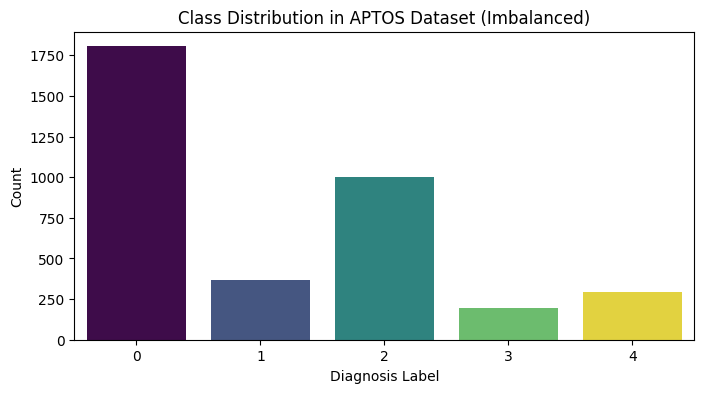

In [ ]:
# Load data and check class distribution
df = pd.read_csv(CSV_PATH)
print("Total images:", len(df))
print("Class counts:\n", df['diagnosis'].value_counts().sort_index())

# Detect file extension (needed for loading images later)
def detect_ext(img_dir, sample_id):
    files = glob.glob(os.path.join(img_dir, sample_id + ".*"))
    return os.path.splitext(files[0])[1] if files else ".png"

ext = detect_ext(IMG_DIR, df['id_code'].iloc[0])
print("\nDetected image extension:", ext)

# Class Distribution Plot (Heatmap/Bar chart for EDA)
plt.figure(figsize=(8,4))
sns.countplot(x='diagnosis', hue='diagnosis', data=df, palette='viridis', legend=False)
plt.title("Class Distribution in APTOS Dataset (Imbalanced)")
plt.xlabel("Diagnosis Label")
plt.ylabel("Count")
plt.show()


Showing random sample images:


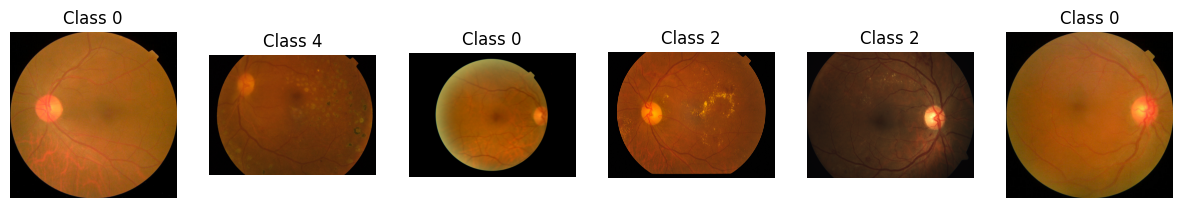

In [ ]:
# Sample Images Visualization (EDA)
def show_samples(n=6, seed=42):
    random.seed(seed)
    ids = random.sample(list(df['id_code']), n)
    plt.figure(figsize=(15, 4))
    for i, idc in enumerate(ids):
        p = os.path.join(IMG_DIR, idc + ext)
        # Use try-except in case of bad image file
        try:
            img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
            plt.subplot(1, n, i+1)
            plt.imshow(img)
            plt.title(f"Class {df[df['id_code'] == idc]['diagnosis'].iloc[0]}")
            plt.axis("off")
        except Exception as e:
            print(f"Could not load image {idc}: {e}")

    plt.show()

print("\nShowing random sample images:")
show_samples(n=6)

# Image Pre-processing and Helpers

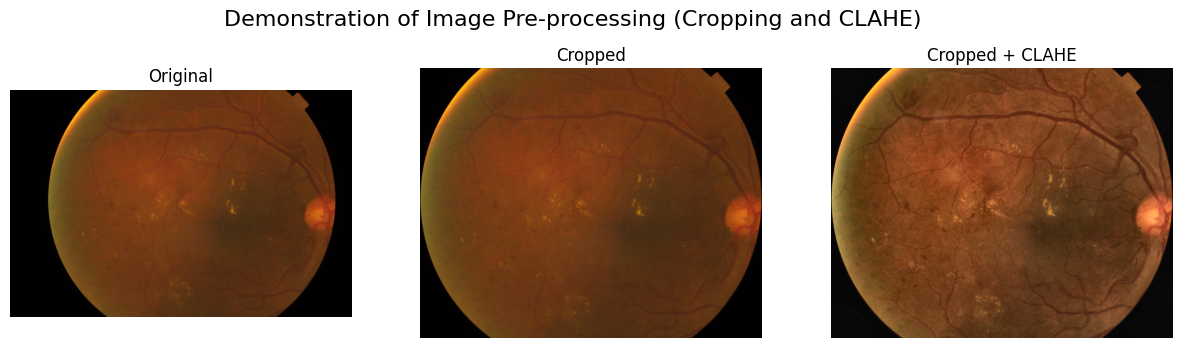

In [ ]:
# Crop helper & CLAHE functions
def crop_border_rgb(img, tol=7):
    """Crops black borders from the image."""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray > tol
    if mask.any():
        coords = np.argwhere(mask)
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0) + 1
        return img[y0:y1, x0:x1]
    return img

def apply_clahe(img):
    """Applies Contrast Limited Adaptive Histogram Equalization."""
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)


# Visualization of Pre-processing
sample_id = df['id_code'].iloc[0]
img_path = os.path.join(IMG_DIR, sample_id + ext)
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

cropped = crop_border_rgb(img)
clahe_img = apply_clahe(cropped)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(cropped); plt.title("Cropped"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(clahe_img); plt.title("Cropped + CLAHE"); plt.axis("off")
plt.suptitle("Demonstration of Image Pre-processing (Cropping and CLAHE)", fontsize=16)
plt.show()

# Transforms & Dataset

In [ ]:
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A

IMG_MEAN = (0.485, 0.456, 0.406)
IMG_STD = (0.229, 0.224, 0.225)

def get_transforms(img_size=380, is_train=True):
    """Defines the data augmentation and normalization pipeline."""
    resize_tuple = (img_size, img_size)

    if is_train:
        return A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_CONSTANT),
            A.RandomResizedCrop(size=resize_tuple, scale=(0.8, 1.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.RandomRotate90(p=0.3),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.5),
            A.OneOf([A.GaussNoise(), A.ISONoise()], p=0.2),
            A.Affine(translate_percent=0.05, scale=(0.9,1.1), rotate=(-15,15), p=0.4),
            A.Normalize(mean=IMG_MEAN, std=IMG_STD),
            ToTensorV2(),
        ])
    else:
        # Standard validation/test set transforms
        return A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_CONSTANT),
            A.Resize(height=img_size, width=img_size),
            A.Normalize(mean=IMG_MEAN, std=IMG_STD),
            ToTensorV2(),
        ])

class APTOSDataset(Dataset):
    """Custom Dataset class for APTOS images."""
    def __init__(self, df, img_dir, transforms=None, ext=".png", crop_border=False, clahe=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transforms = transforms
        self.ext = ext
        self.crop_border = crop_border
        self.clahe = clahe

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + self.ext)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        # Apply pre-processing helpers
        if self.crop_border: img = crop_border_rgb(img)
        if self.clahe: img = apply_clahe(img)

        if self.transforms: img = self.transforms(image=img)['image']

        return img, int(row['diagnosis'])

# Loaders (with stratified 80/10/10 split)

In [ ]:
def make_loaders(data_dir=DATA_DIR, img_size=380, batch_size=8, crop=True, clahe=True, random_state=42):
    """Creates train/val/test data loaders with an 80/10/10 stratified split."""
    df = pd.read_csv(os.path.join(data_dir, "train.csv"))
    ext = detect_ext(os.path.join(data_dir,"train_images"), df['id_code'].iloc[0])

    # Stratified 80/10/10 split
    train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["diagnosis"], random_state=random_state)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["diagnosis"], random_state=random_state)

    train_ds = APTOSDataset(train_df, os.path.join(data_dir,"train_images"), transforms=get_transforms(img_size, is_train=True), ext=ext, crop_border=crop, clahe=clahe)
    val_ds = APTOSDataset(val_df, os.path.join(data_dir,"train_images"), transforms=get_transforms(img_size, is_train=False), ext=ext, crop_border=crop, clahe=clahe)
    test_ds = APTOSDataset(test_df, os.path.join(data_dir,"train_images"), transforms=get_transforms(img_size, is_train=False), ext=ext, crop_border=crop, clahe=clahe)

    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True),
        DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True),
        DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True),
        train_df, val_df, test_df
    )

# Model Architecture and Training Utilities

In [ ]:
# Model Architecture
def create_model(model_name="resnet50d", num_classes=5, pretrained=False):
    # timm handles the complex ResNet layers (layer1, layer2, etc.) internally.
    model = timm.create_model(model_name, pretrained=pretrained)
    model.reset_classifier(num_classes)
    return model

# Optimizer and Training/Evaluation Functions
def get_optimizer(model, lr=1e-4):
    """Returns an Adam optimizer for the entire model."""
    return optim.Adam(model.parameters(), lr=lr)

def train_one_epoch(model, loader, optimizer, criterion, device, scaler=None):
    """Performs a single training epoch."""
    model.train()
    total_loss = 0
    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Use mixed precision for efficiency if a CUDA scaler is available
        if scaler:
            with torch.amp.autocast(device_type="cuda"):
                out = model(imgs)
                loss = criterion(out, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)

def evaluate_on_loader(model, loader, device="cuda"):
    """Calculates evaluation metrics (accuracy, F1, QWK)."""
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            out = model(imgs)
            p = out.argmax(dim=1).cpu().numpy()
            preds.extend(p.tolist())
            trues.extend(labels.numpy().tolist())

    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro')
    qwk = cohen_kappa_score(trues, preds, weights='quadratic')
    cm = confusion_matrix(trues, preds)
    return {"accuracy": acc, "macro_f1": f1, "qwk": qwk, "cm": cm}

def evaluate_loss(model, loader, criterion, device):
    """Calculates the average loss on a given data loader."""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)

# Main Training Loop (Train From Scratch)

In [ ]:
# Setup for Training
SAVE_DIR = "/content/drive/MyDrive/aptos/models"
os.makedirs(SAVE_DIR, exist_ok=True)
scaler = torch.amp.GradScaler("cuda") if device == "cuda" else None

# Single, unified training parameters (380px, crop/clahe is the final, best setup)
IMG_SIZE = 380
BATCH_SIZE = 16
LR = 1e-4
MAX_EPOCHS = 10

# Setup Data Loaders
train_loader, val_loader, test_loader, train_df, val_df, test_df = make_loaders(
    img_size=IMG_SIZE, batch_size=BATCH_SIZE, crop=True, clahe=True
)

# Data Balancing (via Class Weights in Loss Function)
classes = np.unique(train_df['diagnosis'])
weights = compute_class_weight("balanced", classes=classes, y=train_df['diagnosis'])
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
print("Class weights applied for data balancing (Loss function):", weights)

# Model Setup
model = create_model("resnet50d", 5, pretrained=False).to(device)
# Train all layers from the start, as we are training from scratch
opt = get_optimizer(model, lr=LR)
sched = ReduceLROnPlateau(opt, mode='max', patience=2, factor=0.5)

history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": [], "val_qwk": []}
best_qwk = -1
best_model_wts = copy.deepcopy(model.state_dict())

print(f"\nStarting Training from Scratch @ {IMG_SIZE}px for {MAX_EPOCHS} epochs ---")

# Core Training Loop
for epoch in range(MAX_EPOCHS):
    loss = train_one_epoch(model, train_loader, opt, criterion, device, scaler)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    metrics = evaluate_on_loader(model, val_loader, device)
    sched.step(metrics['qwk'])

    # Save metrics for plotting
    history["train_loss"].append(loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(metrics["accuracy"])
    history["val_f1"].append(metrics["macro_f1"])
    history["val_qwk"].append(metrics["qwk"])

    print(f"🔥 Epoch {epoch+1}/{MAX_EPOCHS} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f} "
          f"| Val Acc: {metrics['accuracy']:.4f} | Val QWK: {metrics['qwk']:.4f}")

    # Save best checkpoint based on QWK
    if metrics['qwk'] > best_qwk:
        best_qwk = metrics['qwk']
        best_model_wts = copy.deepcopy(model.state_dict())
        save_path = os.path.join(SAVE_DIR, f"resnet50d_scratch_best_{IMG_SIZE}_001.pth")
        torch.save(best_model_wts, save_path)
        print(f"✨ Saved new best model to {save_path} (QWK={best_qwk:.4f})")

model.load_state_dict(best_model_wts)
print("\n-Training Complete. Best Validation QWK:", best_qwk)

Class weights applied for data balancing (Loss function): [0.40567867 1.97905405 0.73316646 3.8038961  2.48220339]

Starting Training from Scratch @ 380px for 10 epochs ---


100%|██████████| 184/184 [12:08<00:00,  3.96s/it]


🔥 Epoch 1/10 | Train Loss: 1.6161 | Val Loss: 1.4928 | Val Acc: 0.4617 | Val QWK: 0.3232
✨ Saved new best model to /content/drive/MyDrive/aptos/models/resnet50d_scratch_best_380_001.pth (QWK=0.3232)


100%|██████████| 184/184 [11:30<00:00,  3.75s/it]


🔥 Epoch 2/10 | Train Loss: 1.5243 | Val Loss: 1.4572 | Val Acc: 0.4481 | Val QWK: 0.3433
✨ Saved new best model to /content/drive/MyDrive/aptos/models/resnet50d_scratch_best_380_001.pth (QWK=0.3433)


100%|██████████| 184/184 [11:33<00:00,  3.77s/it]


🔥 Epoch 3/10 | Train Loss: 1.4961 | Val Loss: 1.4215 | Val Acc: 0.3962 | Val QWK: 0.2324


100%|██████████| 184/184 [11:34<00:00,  3.77s/it]


🔥 Epoch 4/10 | Train Loss: 1.4770 | Val Loss: 1.3404 | Val Acc: 0.5820 | Val QWK: 0.6106
✨ Saved new best model to /content/drive/MyDrive/aptos/models/resnet50d_scratch_best_380_001.pth (QWK=0.6106)


100%|██████████| 184/184 [11:43<00:00,  3.82s/it]


🔥 Epoch 5/10 | Train Loss: 1.4422 | Val Loss: 1.3323 | Val Acc: 0.5137 | Val QWK: 0.6089


100%|██████████| 184/184 [11:39<00:00,  3.80s/it]


🔥 Epoch 6/10 | Train Loss: 1.4100 | Val Loss: 1.4229 | Val Acc: 0.5219 | Val QWK: 0.4299


100%|██████████| 184/184 [11:34<00:00,  3.77s/it]


🔥 Epoch 7/10 | Train Loss: 1.3873 | Val Loss: 1.3090 | Val Acc: 0.5574 | Val QWK: 0.5494


100%|██████████| 184/184 [11:32<00:00,  3.76s/it]


🔥 Epoch 8/10 | Train Loss: 1.3209 | Val Loss: 1.2660 | Val Acc: 0.6257 | Val QWK: 0.6353
✨ Saved new best model to /content/drive/MyDrive/aptos/models/resnet50d_scratch_best_380_001.pth (QWK=0.6353)


100%|██████████| 184/184 [11:38<00:00,  3.79s/it]


🔥 Epoch 9/10 | Train Loss: 1.3113 | Val Loss: 1.2611 | Val Acc: 0.5410 | Val QWK: 0.6087


100%|██████████| 184/184 [11:34<00:00,  3.78s/it]


🔥 Epoch 10/10 | Train Loss: 1.3089 | Val Loss: 1.2534 | Val Acc: 0.5984 | Val QWK: 0.6609
✨ Saved new best model to /content/drive/MyDrive/aptos/models/resnet50d_scratch_best_380_001.pth (QWK=0.6609)

-Training Complete. Best Validation QWK: 0.6609296804078117


# Final Evaluation and Results

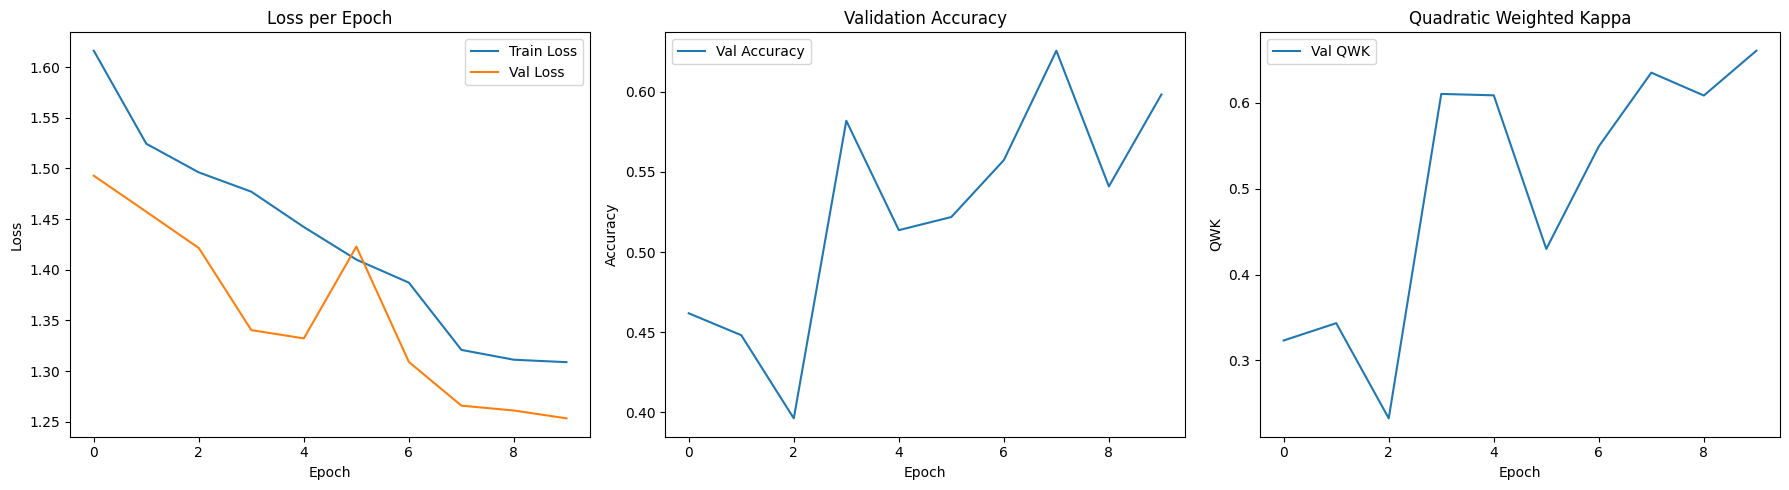

In [ ]:
# Training Curves Plot
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss'); plt.plot(history['val_loss'], label='Val Loss')
plt.title("Loss per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.subplot(1, 3, 2)
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title("Validation Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
plt.subplot(1, 3, 3)
plt.plot(history['val_qwk'], label='Val QWK')
plt.title("Quadratic Weighted Kappa"); plt.xlabel("Epoch"); plt.ylabel("QWK"); plt.legend()
plt.tight_layout()
plt.show()

Loaded best model from /content/drive/MyDrive/aptos/models/resnet50d_scratch_best_380_001.pth


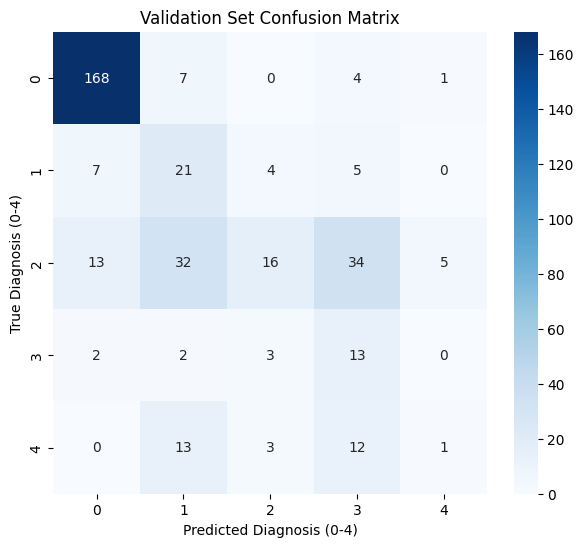

In [ ]:
# Evaluate and Load Best Model
try:
    # Load the best model checkpoint path
    best_model_path = os.path.join(SAVE_DIR, f"resnet50d_scratch_best_{IMG_SIZE}_001.pth")
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"Loaded best model from {best_model_path}")
except Exception as e:
    print(f"Could not load saved model. Using weights from the end of training. Error: {e}")


val_metrics = evaluate_on_loader(model, val_loader, device=device)

# Confusion Matrix Plot: Validation Set
plt.figure(figsize=(7, 6))
sns.heatmap(val_metrics["cm"], annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.title("Validation Set Confusion Matrix")
plt.xlabel("Predicted Diagnosis (0-4)");
plt.ylabel("True Diagnosis (0-4)")
plt.show()

In [ ]:
# Evaluate on Test Set
try:
    # Load the best model checkpoint path
    best_model_path = os.path.join(SAVE_DIR, f"resnet50d_scratch_best_{IMG_SIZE}_001.pth")
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"Loaded best model from {best_model_path}")
except Exception as e:
    print(f"Could not load saved model. Using weights from the end of training. Error: {e}")

test_metrics = evaluate_on_loader(model, test_loader, device=device)

print("\nTEST PERFORMANCE (Best Model)")
print(f"Accuracy     : {test_metrics['accuracy']:.4f}")
print(f"Macro F1     : {test_metrics['macro_f1']:.4f}")
print(f"QWK (Kappa)  : {test_metrics['qwk']:.4f}")

Loaded best model from /content/drive/MyDrive/aptos/models/resnet50d_scratch_best_380_001.pth

TEST PERFORMANCE (Best Model)
Accuracy     : 0.6185
Macro F1     : 0.3861
QWK (Kappa)  : 0.6759


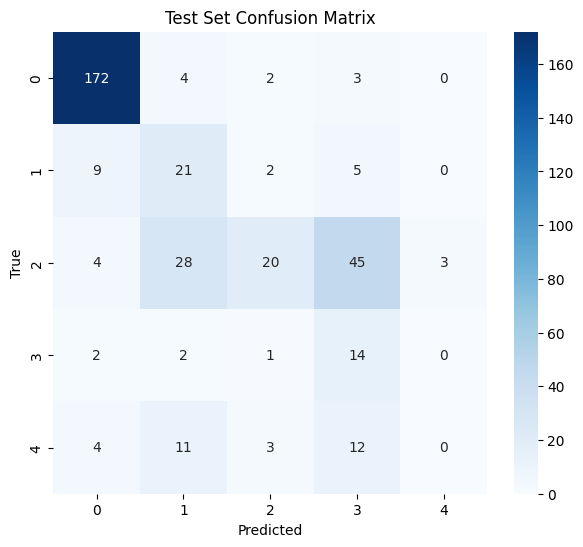

In [ ]:
# Confusion Matrix Plot
plt.figure(figsize=(7, 6))
sns.heatmap(test_metrics["cm"], annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

In [ ]:
# Classification Report
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        preds = out.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print("\n", classification_report(y_true, y_pred, digits=3))


               precision    recall  f1-score   support

           0      0.901     0.950     0.925       181
           1      0.318     0.568     0.408        37
           2      0.714     0.200     0.312       100
           3      0.177     0.737     0.286        19
           4      0.000     0.000     0.000        30

    accuracy                          0.619       367
   macro avg      0.422     0.491     0.386       367
weighted avg      0.680     0.619     0.597       367

